# Simulations

In [ ]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import gym
from Nengo.NengoGymCartpole import NengoGymCartpole
from Nengo.NengoModelCartpole import NengoModelCartpole

In [3]:
nengo_gym_cartpole = NengoGymCartpole(update_each=70)

Gym Init
Action Space:
Discrete(2)
Observation Space:
Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


In [4]:
nengo_cartpole_model = NengoModelCartpole(nengo_gym_cartpole)

[0. 0.]


In [5]:
from nengo_gui.ipython import IPythonViz
IPythonViz(nengo_cartpole_model, 'my-model.cfg')

In [ ]:
def plot_running_avg(totalrewards):
    N = len(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = totalrewards[max(0, t-100):(t+1)].mean()
    plt.plot(running_avg)
    plt.title("Running Average of rewards")
    plt.xlabel("Simulation time")
    plt.ylabel("Score")
    plt.show()

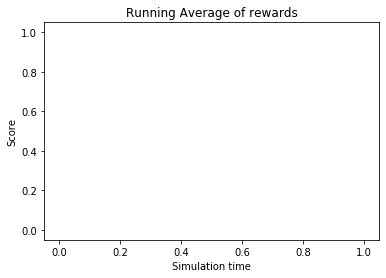

In [6]:
plot_running_avg(np.array(nengo_gym_cartpole.true_total_rewards))

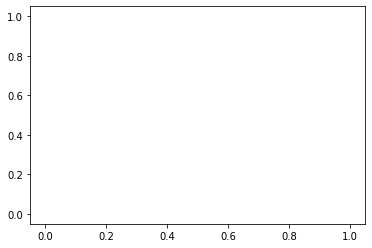

In [7]:
plt.plot(nengo_gym_cartpole.true_total_rewards)

# Architecture sandbox

This setup is used to try out different architecture and see if the neural computation they are performing is the one we are searching for

In [ ]:
import nengo
import numpy as np
import matplotlib.pyplot as plt

FAST_TAU = 0.001
SLOW_TAU = 0.01

with nengo.Network() as model:
    node = nengo.Node(lambda t : [np.sin(20*t), np.cos(20*t)])
    
    state = nengo.Ensemble(2000, 2)
    nengo.Connection(node, state, synapse=0)
    
    value_FAST = nengo.Ensemble(3000, 2)
    
    nengo.Connection(state, value_FAST, synapse=0)
    
    BG = nengo.networks.BasalGanglia(dimensions=2)
    nengo.Connection(value_FAST, BG.input)
    
    thalamus = nengo.networks.Thalamus(dimensions=2)
    nengo.Connection(BG.input, thalamus.input)
    
    probe_FAST = nengo.Probe(value_FAST, synapse=None)
    probe_BG = nengo.Probe(BG.output, synapse=None)
    probe_thalamus = nengo.Probe(thalamus.output, synapse=None)

with nengo.Simulator(model) as sim:
    sim.run(0.5)

In [ ]:
def compute_theory():
    t = np.arange(0, 0.5, 0.001)
    sine = np.sin(20*t)
    
    def compute_td_error(index):
        td = 0.9 * sine[index + 1] - sine[index]

        return td
    
    tds = []

    for index, _ in enumerate(sine[:-1]):
        tds.append(compute_td_error(index))
    
    return t, sine, tds

In [ ]:
t, sine, tds = compute_theory()

rewards = np.ones_like(sine)

In [ ]:
plt.figure(figsize=(15, 10))

plt.plot(sim.data[probe_FAST])
plt.plot(sim.data[probe_BG])
plt.plot(sim.data[probe_thalamus])

plt.legend(["sine", 'cos', "bg_for_sine", "bg_for_cos", "thal_for_sine", "thal_for_cos"])

plt.show()